In [1]:
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
links = re.compile("http[s]?://[a-zA-z./\d]*")
punc = re.compile("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~￥%……&*（）]+")
punc1 = re.compile("[【】╮╯▽╰╭★→「」]+")
punc2 = re.compile("！，❤。～《》：（）【】「」？”“；：、")
fourdots = re.compile("\.*")

def clean(line):
    line = links.sub(' ',line)
    line = punc.sub(' ',line)
    line = punc1.sub(' ',line)
    line = punc2.sub(' ',line)
    line = fourdots.sub('',line)
    return(line)    

In [3]:
with open('../Data/pos_tweets.txt', 'r') as infile:
    pos_tweets = []
    for line in infile:
        pos_tweets.append(clean(line))

with open('../Data/neg_tweets.txt', 'r') as infile:
    neg_tweets = []
    for line in infile:
        neg_tweets.append(clean(line))

y = np.concatenate((np.ones(len(pos_tweets)), np.zeros(len(neg_tweets)))).astype(int).astype(str)
X = np.concatenate((pos_tweets, neg_tweets))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
train_sup = []
train_unsup = []
for i, (xline,yline) in enumerate(zip(x_train,y_train)):
    train_sup.append(TaggedDocument(xline.lower().split(),[i,yline]))
    train_unsup.append(TaggedDocument(xline.lower().split(),[i]))

test_sup = []
test_unsup = []
for i, (xline,yline) in enumerate(zip(x_test,y_test)):
    test_sup.append(TaggedDocument(xline.split(),[i,yline]))
    test_unsup.append(TaggedDocument(xline.split(),[i]))

In [5]:
model_sup = Doc2Vec(vector_size=100, min_count=3, epochs= 100, workers= 20)
model_sup.build_vocab(train_sup)
model_sup.train(train_sup,total_examples=model_sup.corpus_count,epochs=model_sup.epochs)

model_unsup = Doc2Vec(vector_size=100, min_count=3, epochs= 100, workers= 20)
model_unsup.build_vocab(train_unsup)
model_unsup.train(train_unsup,total_examples=model_unsup.corpus_count,epochs=model_unsup.epochs)

In [6]:
def unit(vec):
    if vec.sum():
        vec = vec/np.linalg.norm(vec)
    return vec

pos_sup = unit(model_sup.docvecs['1'])
neg_sup = unit(model_sup.docvecs['0'])

pos_unsup = unit(model_unsup.wv['good'])
neg_unsup = unit(model_unsup.wv['bad'])

In [7]:
def diff(vec,plus_vec,minus_vec):
    return np.dot(vec,plus_vec)-np.dot(vec,minus_vec)
    
outer_sup = [] 
for i in test_sup:
    vec = unit(model_sup.infer_vector(i[0]))
    outer_sup.append(diff(vec,pos_sup,neg_sup))

outer_unsup = []
for i in test_unsup:
    vec = unit(model_unsup.infer_vector(i[0]))
    outer_unsup.append(diff(vec,pos_unsup,neg_unsup))

outer_random = np.random.normal(size=len(y_test))

In [8]:
print("Supervised: ",average_precision_score(y_test,outer_sup,pos_label='1'))
print("Unsupervised: ", average_precision_score(y_test,outer_unsup,pos_label='1'))
print("Random: ",average_precision_score(y_test,outer_random,pos_label='1'))

Supervised:  0.740132292132389
Unsupervised:  0.48373256134894155
Random:  0.3396795484960746


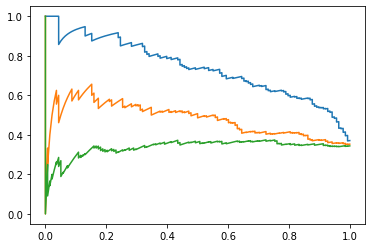

In [9]:
prec_sup, recall_sup, _ = precision_recall_curve(y_test,outer_sup,pos_label='1')
prec_unsup, recall_unsup, _ = precision_recall_curve(y_test,outer_unsup,pos_label='1')
prec_random, recall_random, _ = precision_recall_curve(y_test,outer_random,pos_label='1')

plt.plot(recall_sup,prec_sup)
plt.plot(recall_unsup,prec_unsup)
plt.plot(recall_random,prec_random)
plt.show()